In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import skimage.io as skio
import skimage
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import tifffile
import numpy as np
from utils import *
import os
from pathlib import Path
import trackpy as tp
import scipy
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.stats import anderson
import glob
import matplotlib.animation as animation
import matplotlib.colors as mcolors

In [6]:
def gaussian_2d(xy, x0, y0, sigmax, sigmay, sigmaxy):
    if xy.shape[-1] != 2 or len(xy.shape) != 2:
        raise ValueError("XY data should have shape (n, 2).")
    mu = np.array([x0, y0])
    sigma = np.array([[sigmax, sigmaxy], [sigmaxy, sigmay]])
    normalization = (((2 * np.pi) ** 2) * np.abs(np.linalg.det(sigma))) ** (-1 / 2)
    bell = np.exp(-0.5 * np.sum(((xy - mu) @ np.linalg.inv(sigma)) * (xy - mu), axis=1))
    return normalization * bell

def cov_to_axes_and_rotation(cov, sorted=True):
    """"Takes a covariance matrix and returns the principle axes and a rotation"""
    (e1, e2), eigen_vec = np.linalg.eig(cov)
    V1,V2 = eigen_vec.T
    
    # Eigenvectors are assumed to be unit and orthogonal
    # print(np.linalg.norm(V1))
    e1 = np.real(e1) # sometimes tiny imaginary components are returned. 
    e2 = np.real(e2) # sometimes tiny imaginary components are returned. 
    if np.isclose(e1, e2):
        # the angle is not well defined
        theta = 0

    else:
        # Are eigenvectors always normalized? 
        theta = np.degrees(np.arctan2(V1[1], V1[0]))
    #if theta>90 and theta <180:
    #     theta = 180 - theta
    #print(theta)

    if sorted: #make sure e1 is always the largest
        if e2>e1:
            (e1, e2) = (e2, e1)
            theta = theta + 90

    return e1, e2, np.mod(theta, 360)


In [12]:
fit_method = "lq"
box_side_length = 7
drift = 0
min_gradient = 800

In [11]:
file_directory = r"C:\Users\lizau\Desktop\walker_test\CODE_TEST\1a8\aligned\out"
in_files = glob.glob(f'{file_directory}/*.tif')

In [3]:
px_to_nm = 72
frame_to_s = 0.223

max_link_displacement_px = 2
min_tray_length = 3

Frame 3986: 1 trajectories present.
mean drift  y   -0.664385
x    0.216773
dtype: float32


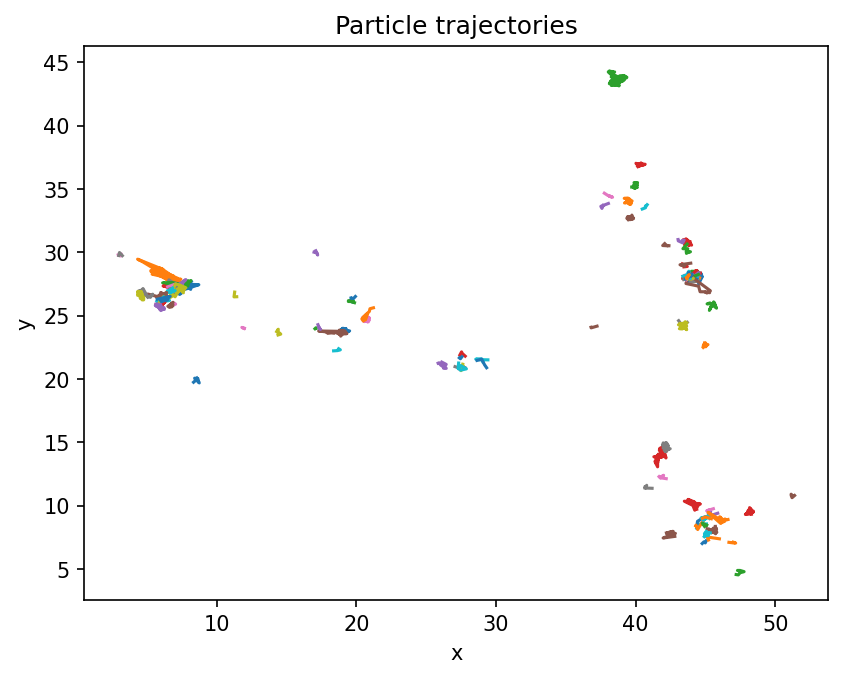

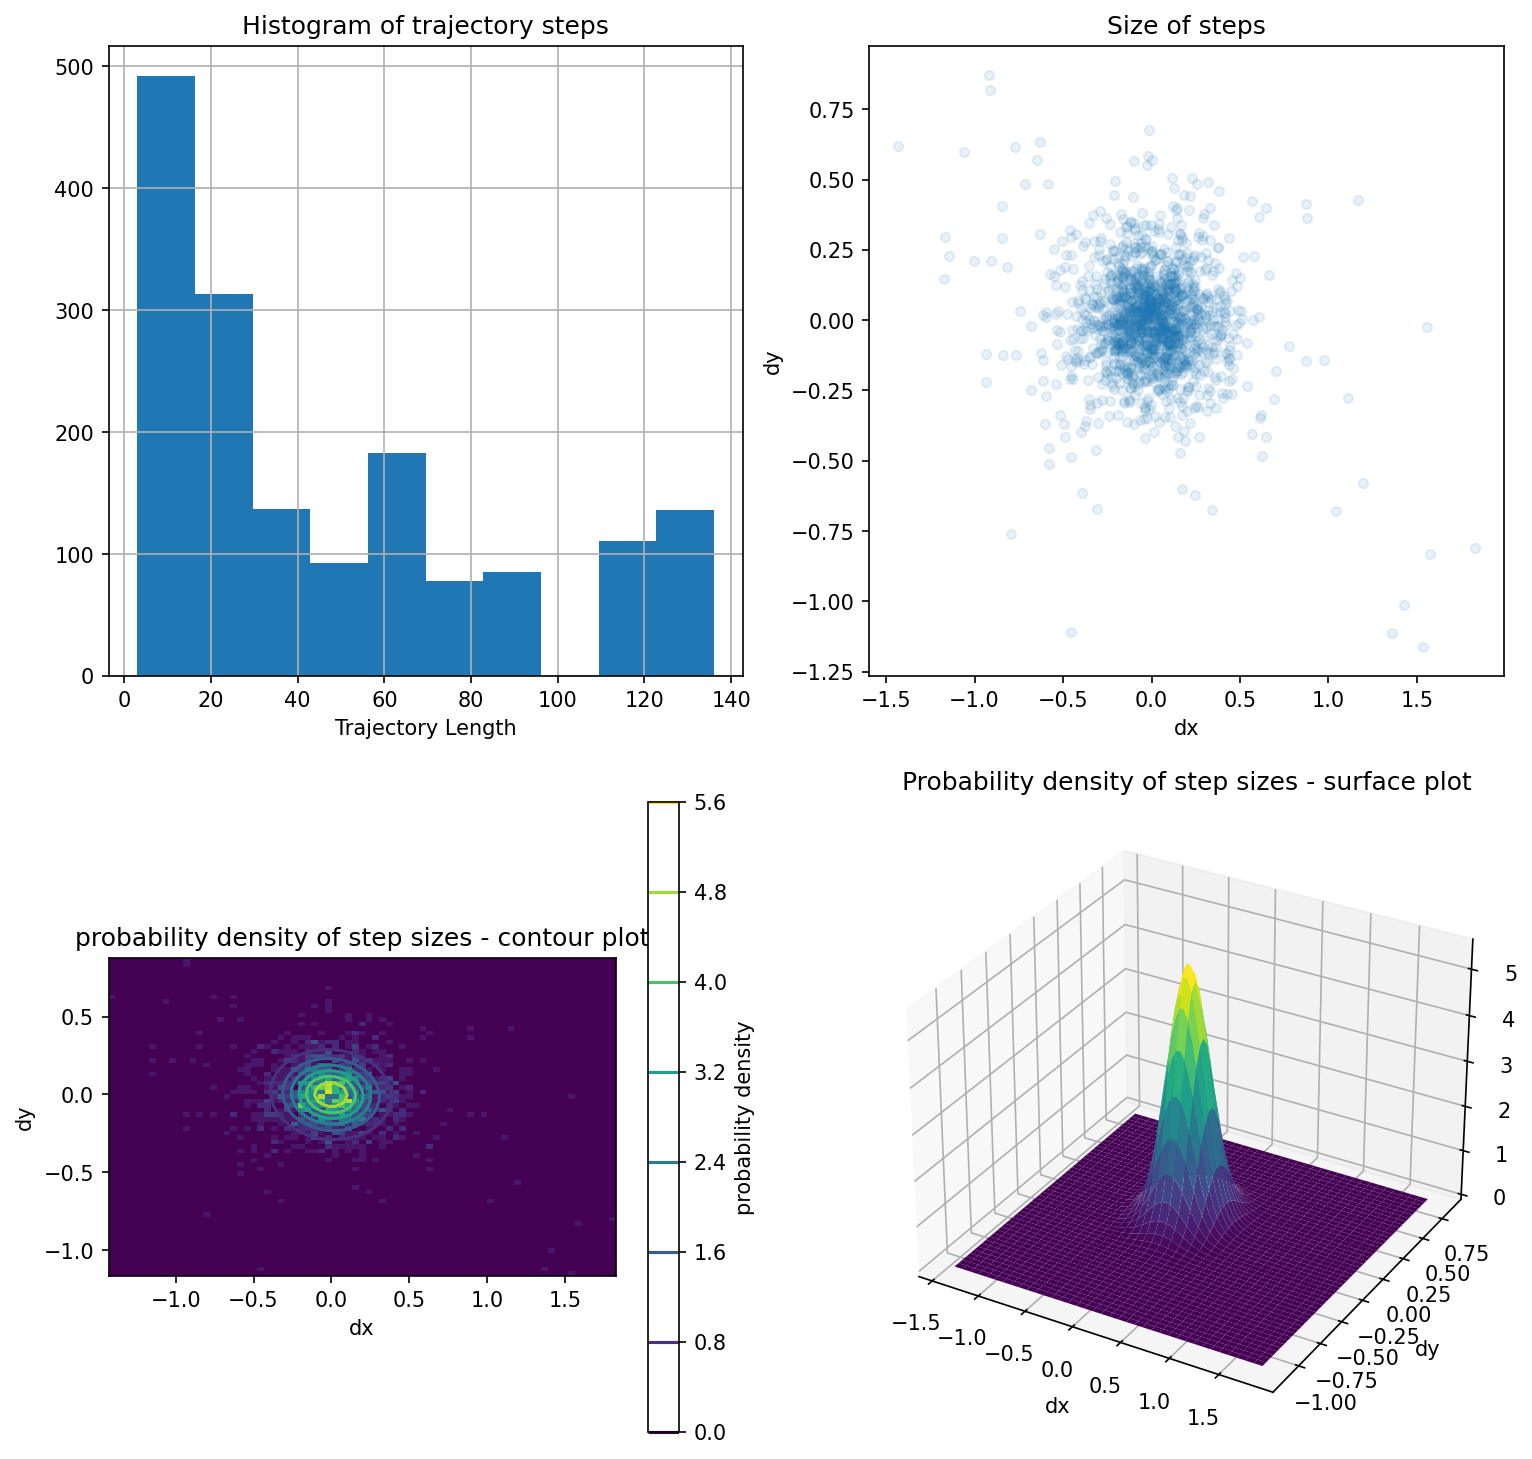

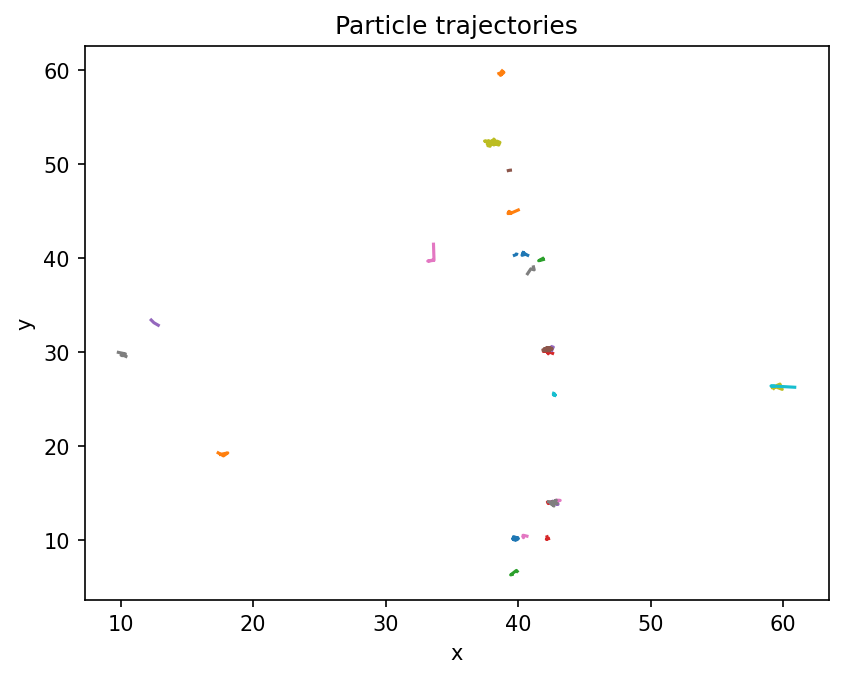

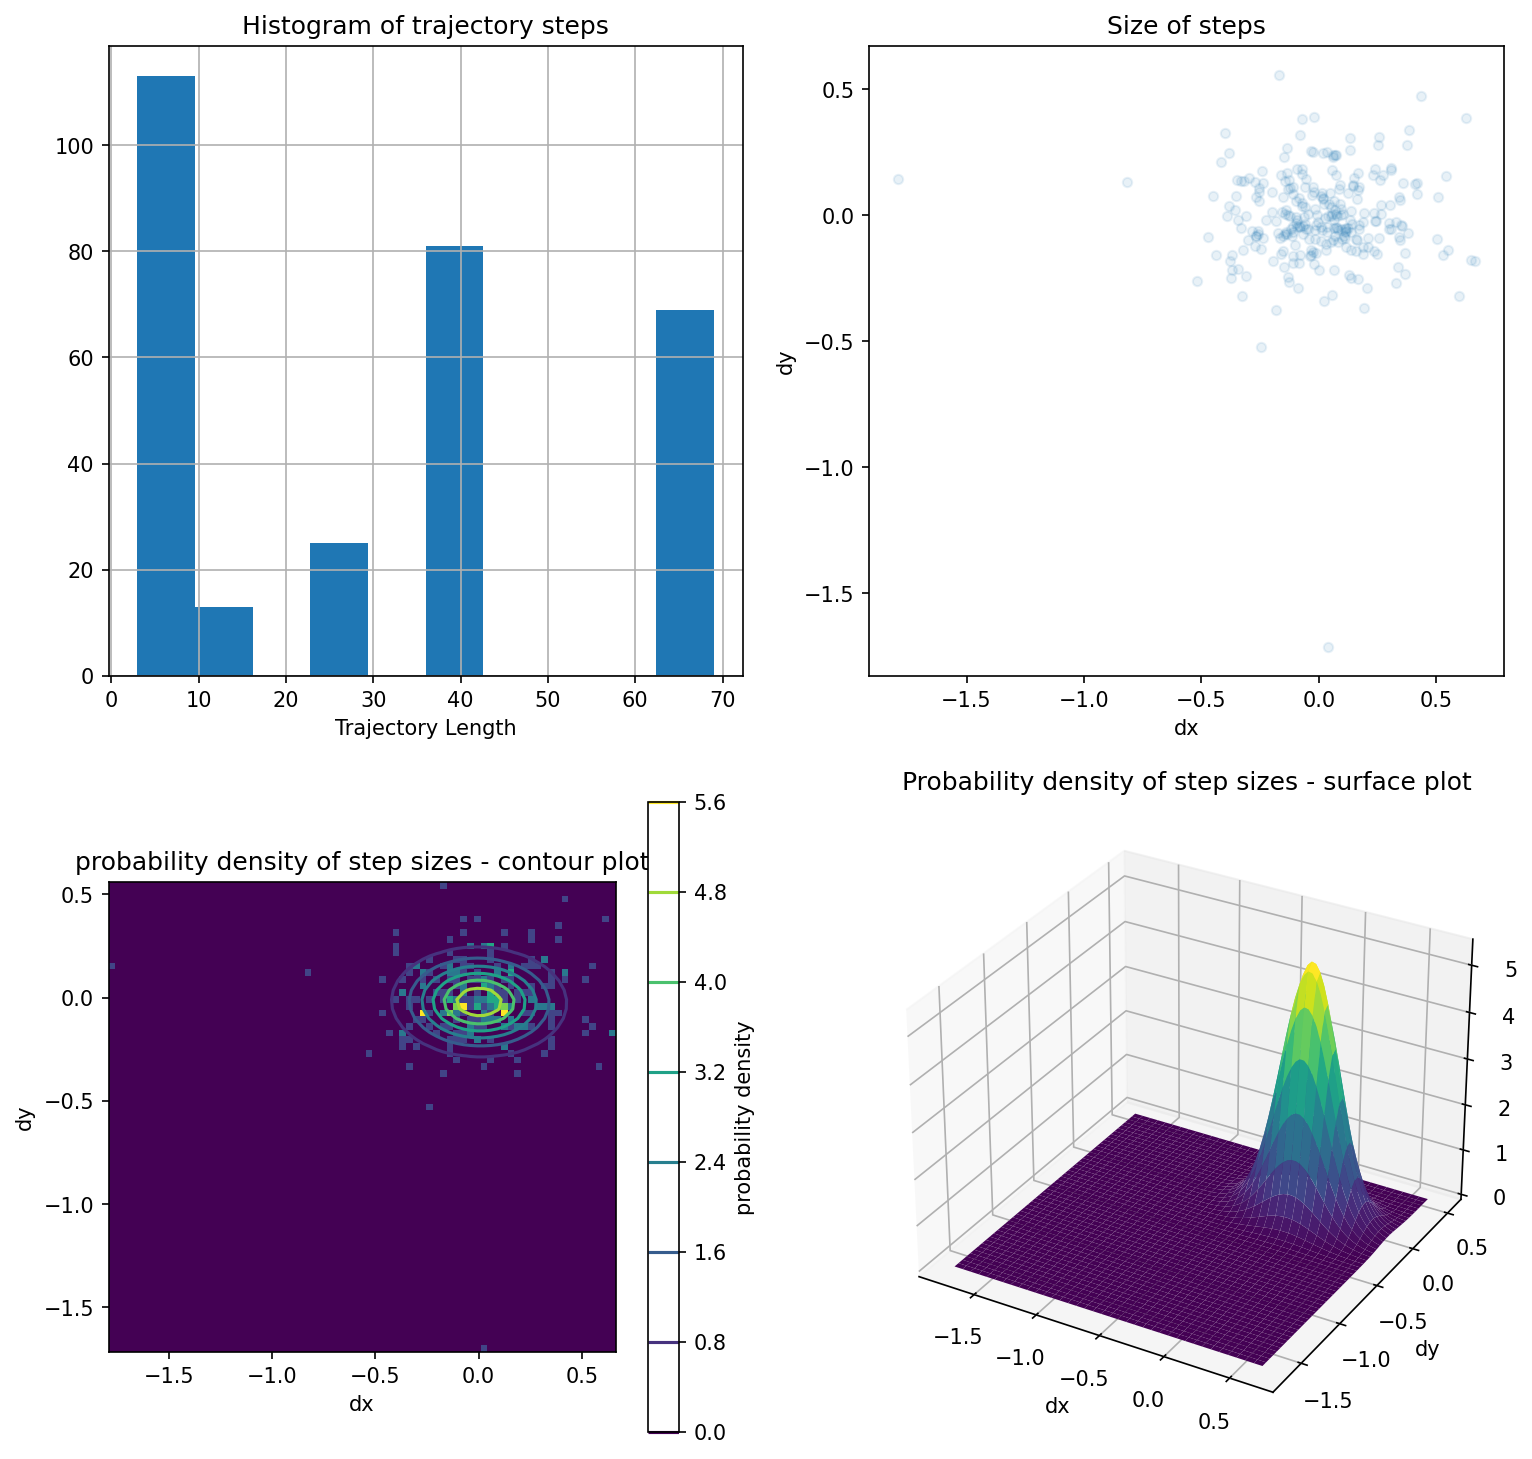

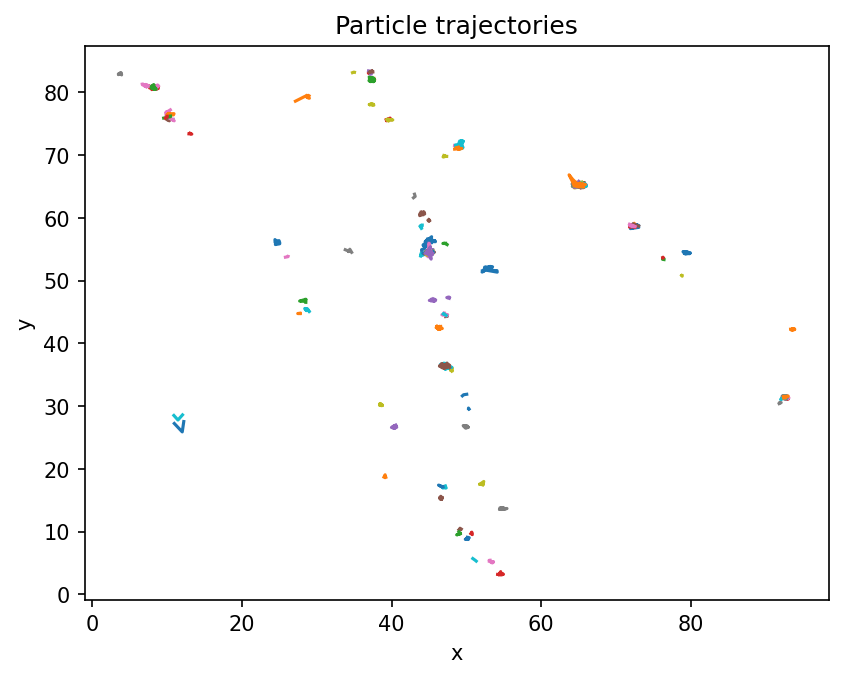

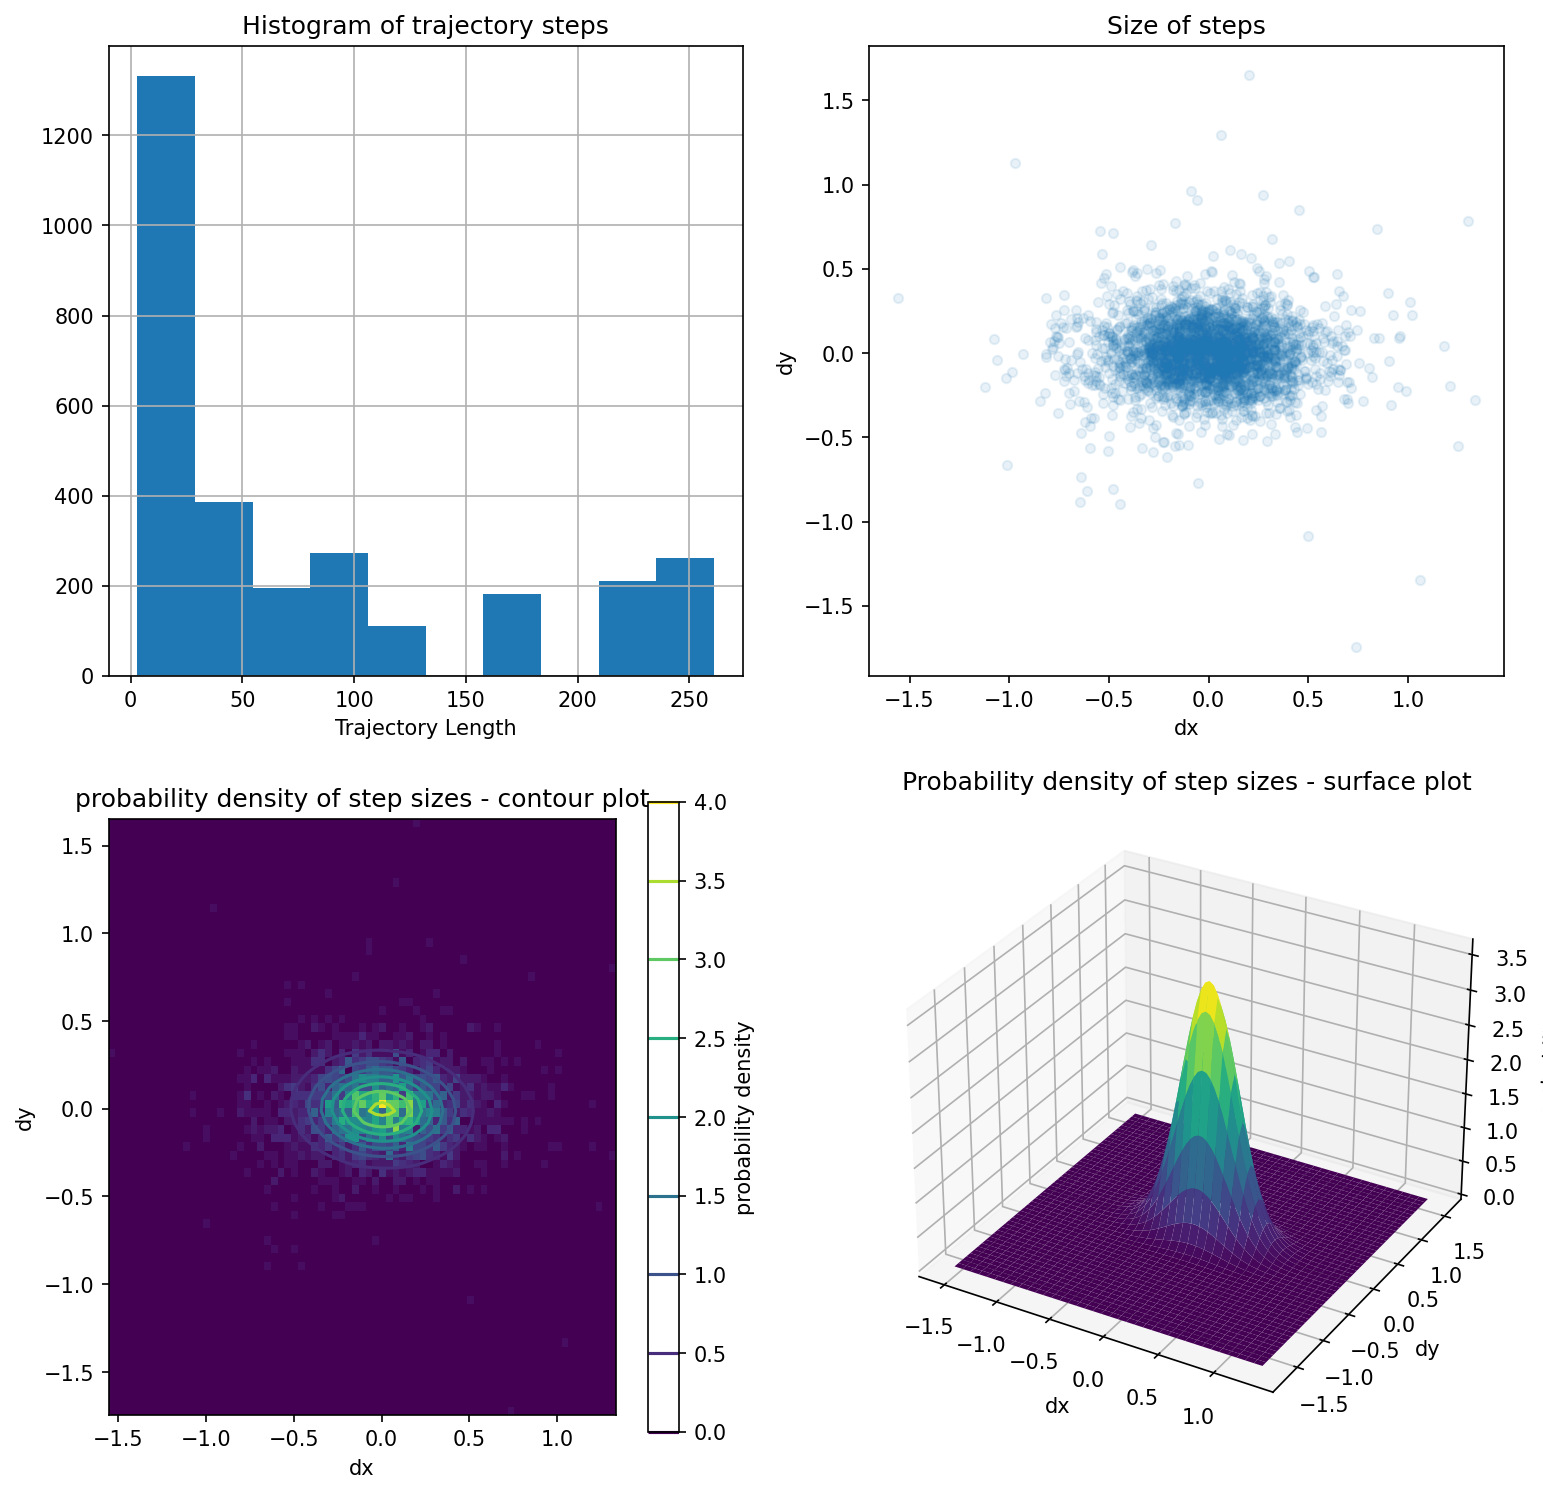

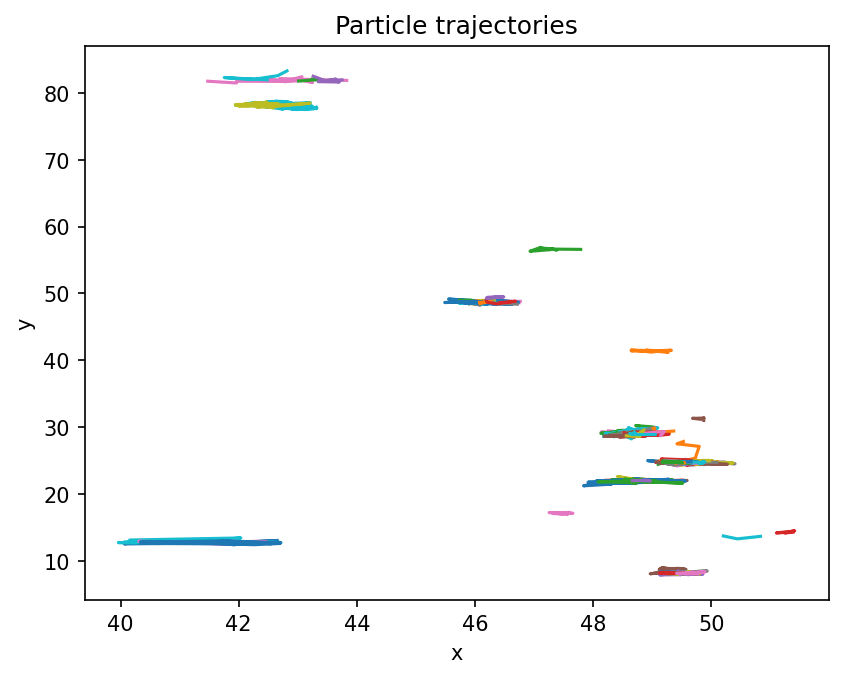

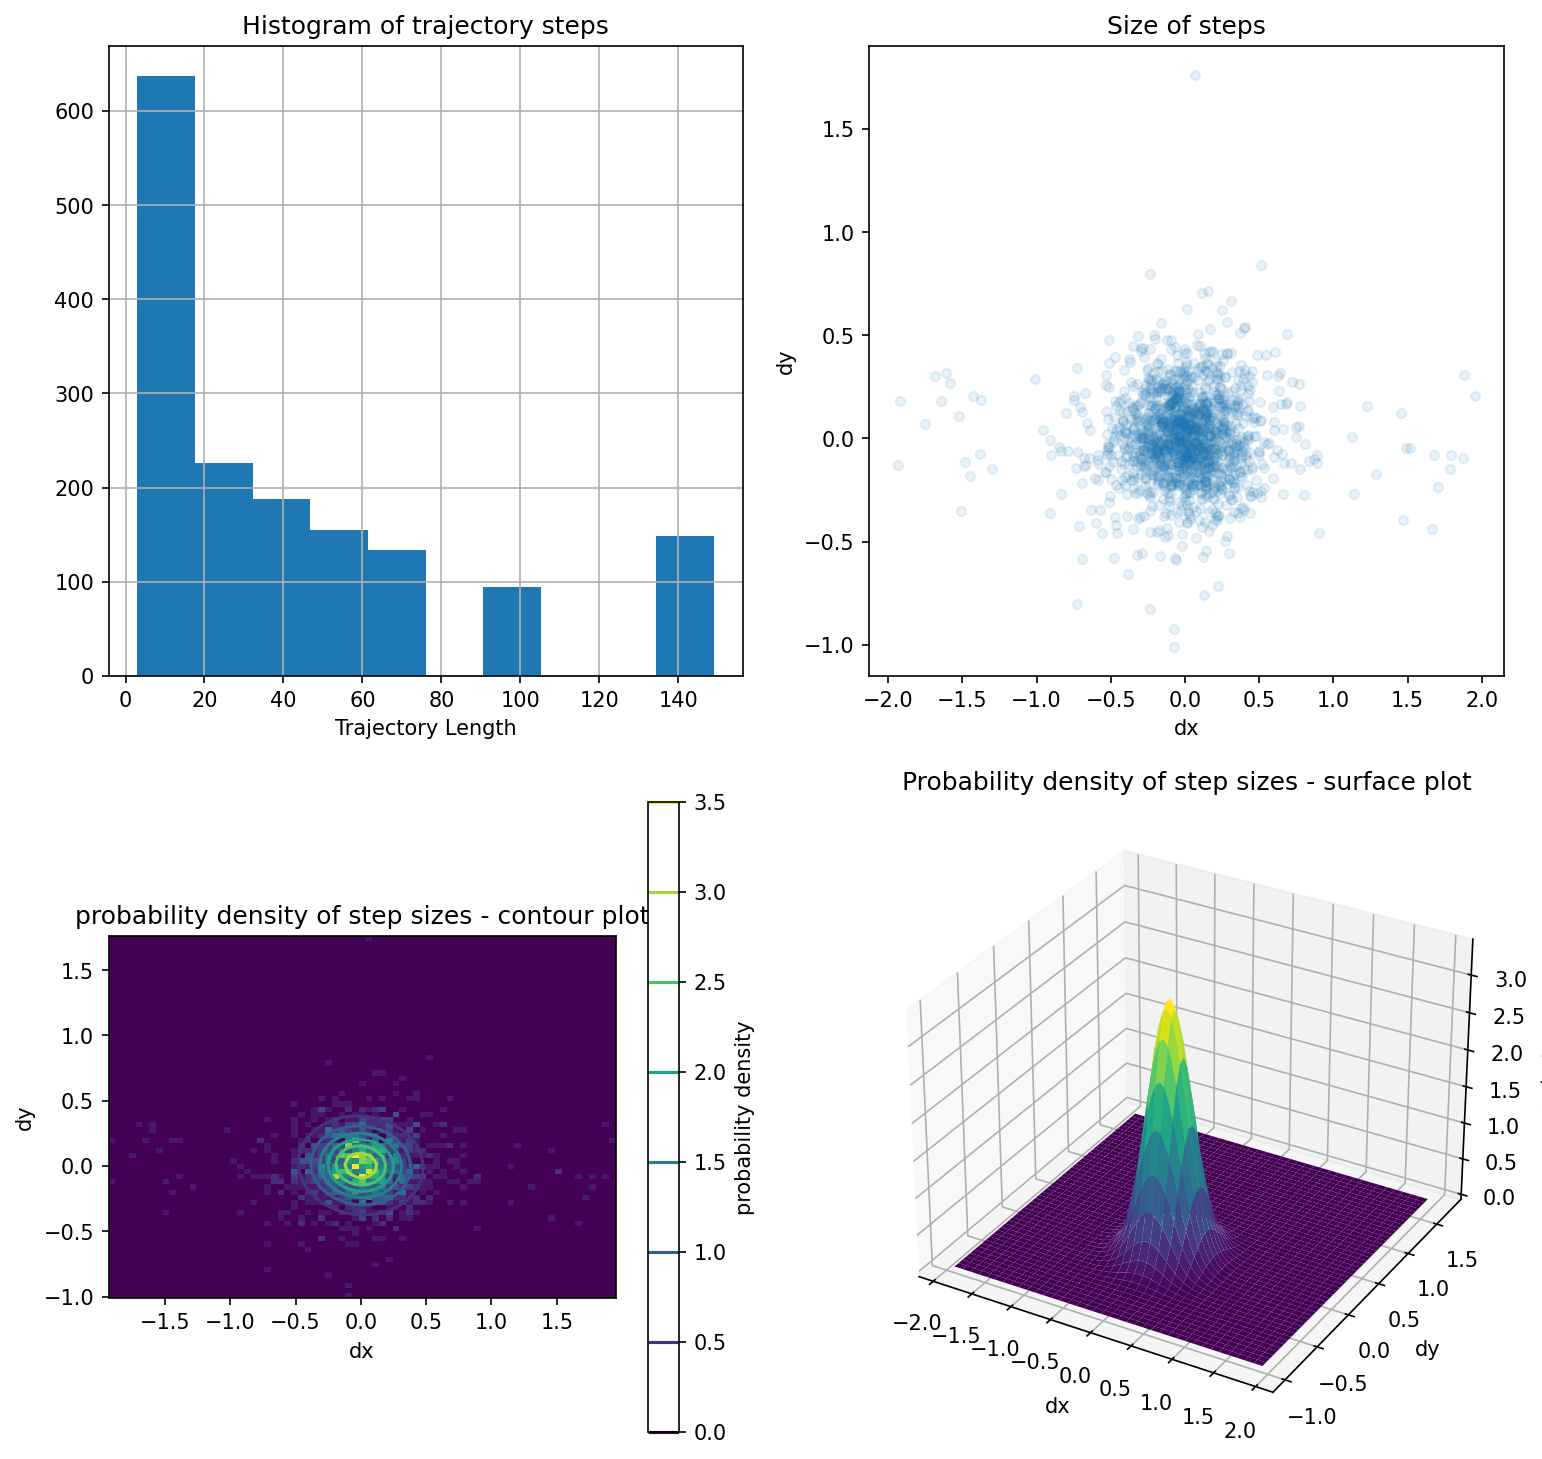

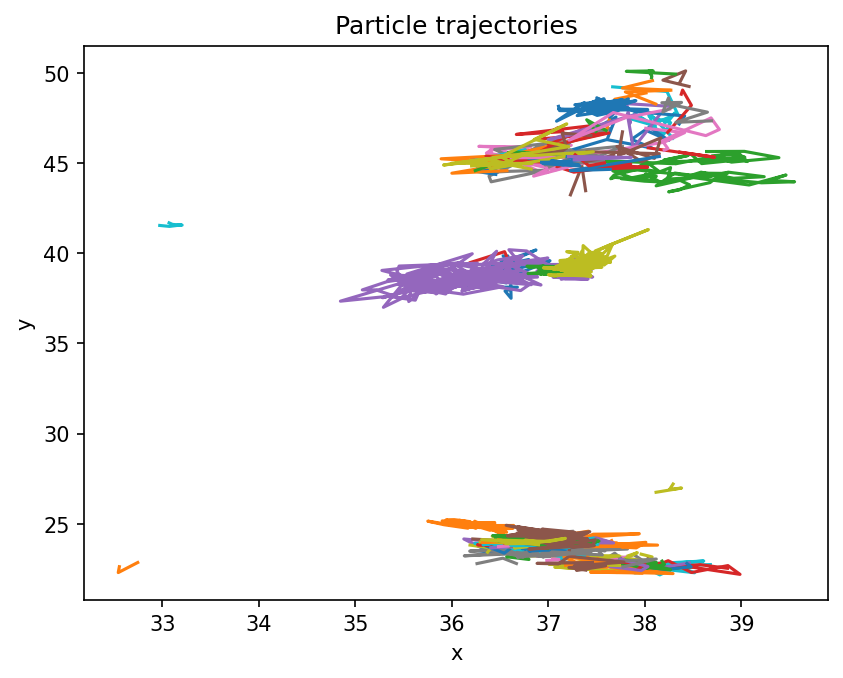

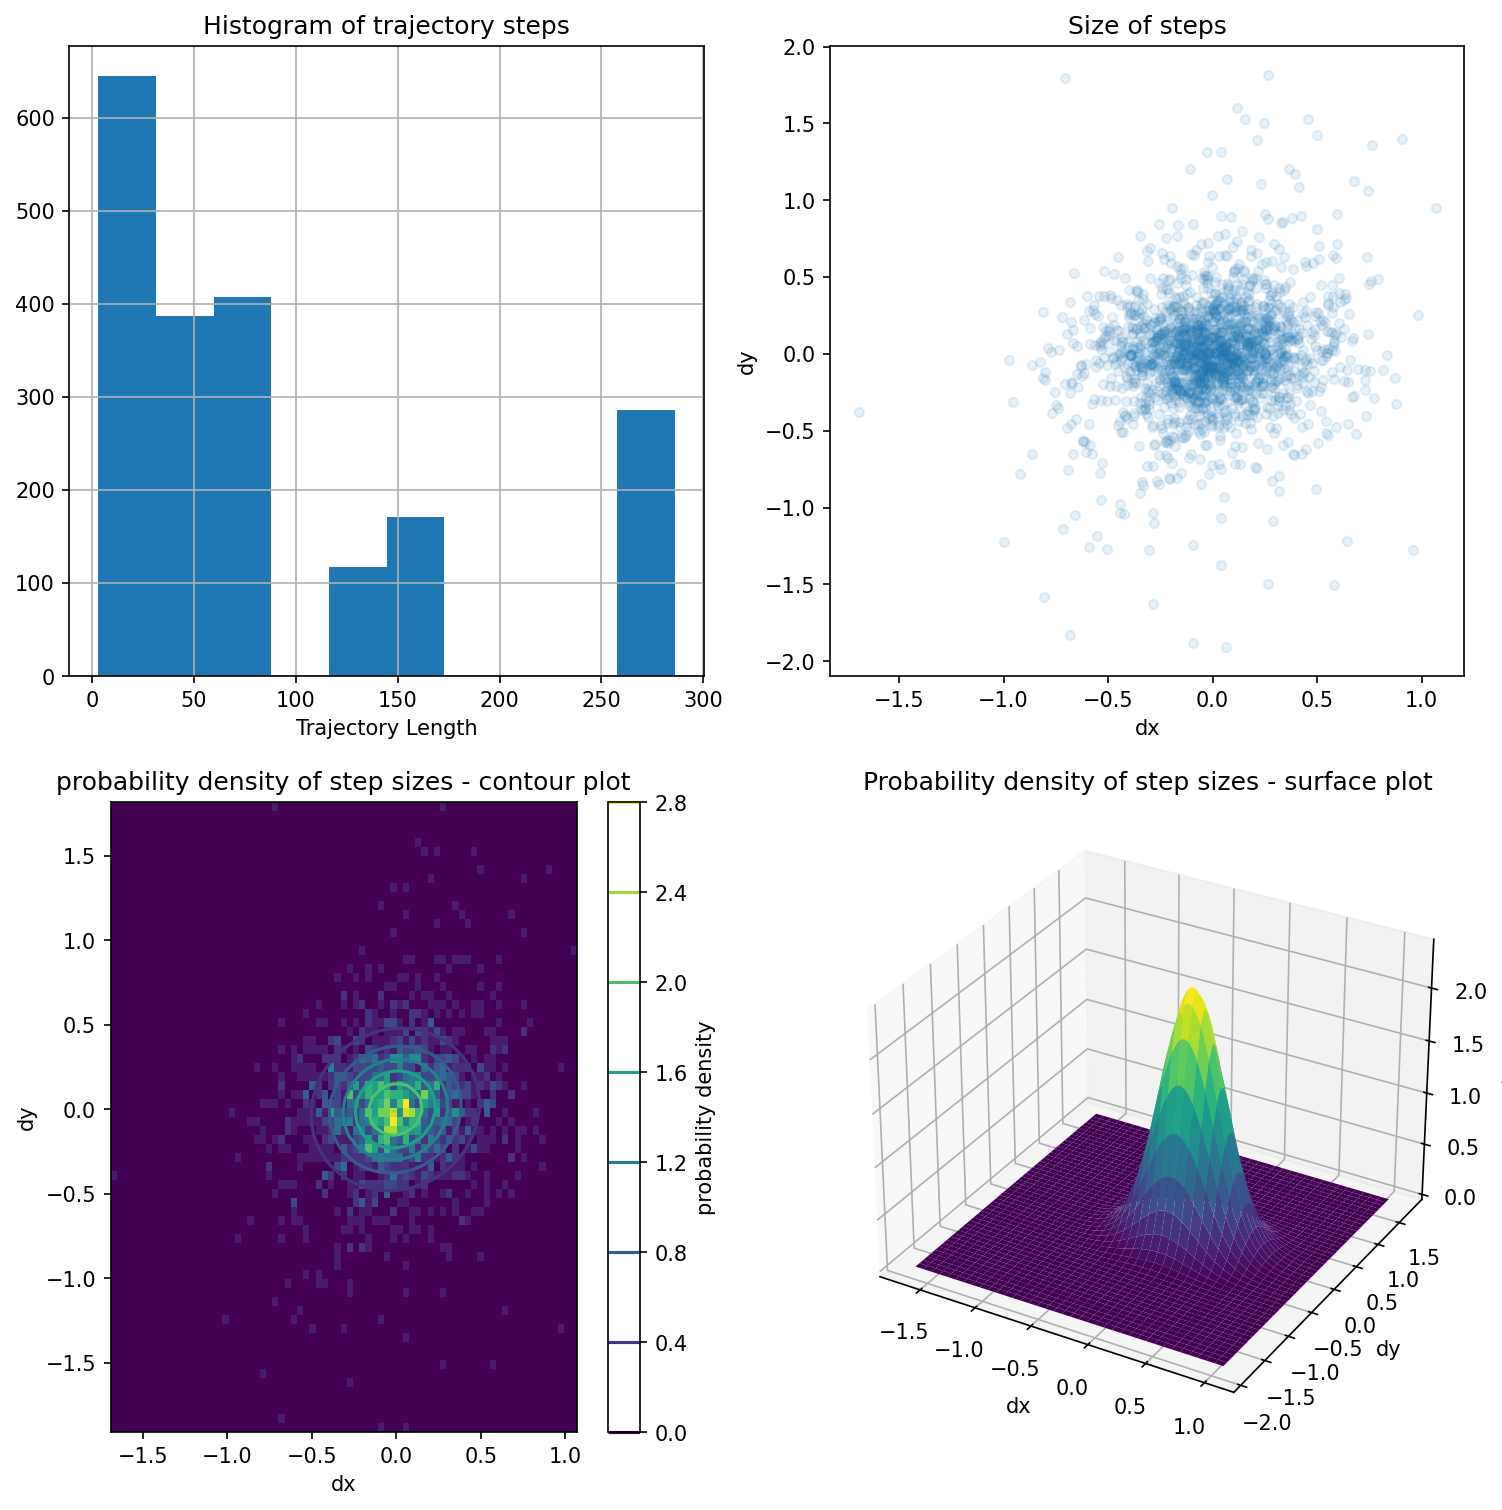

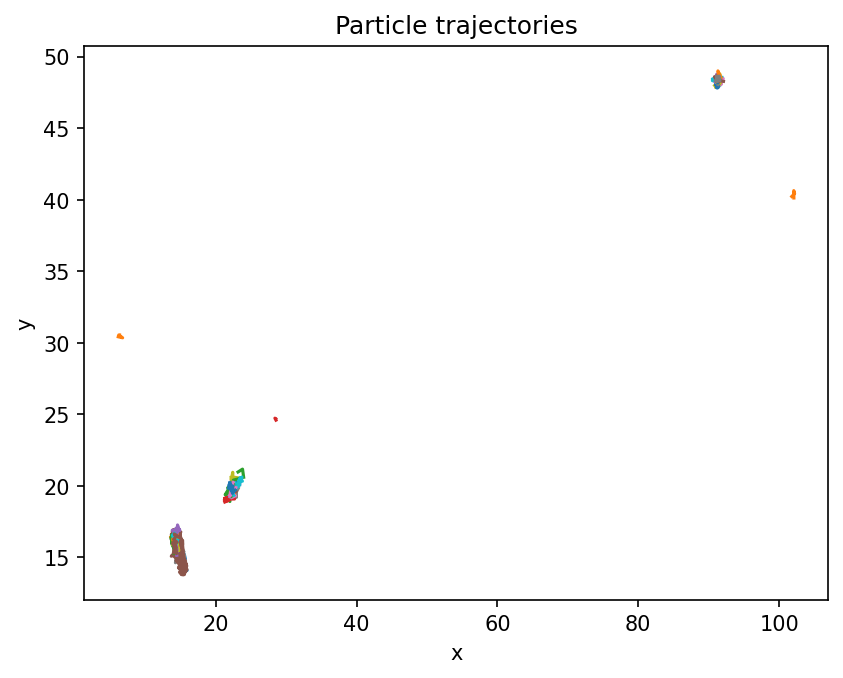

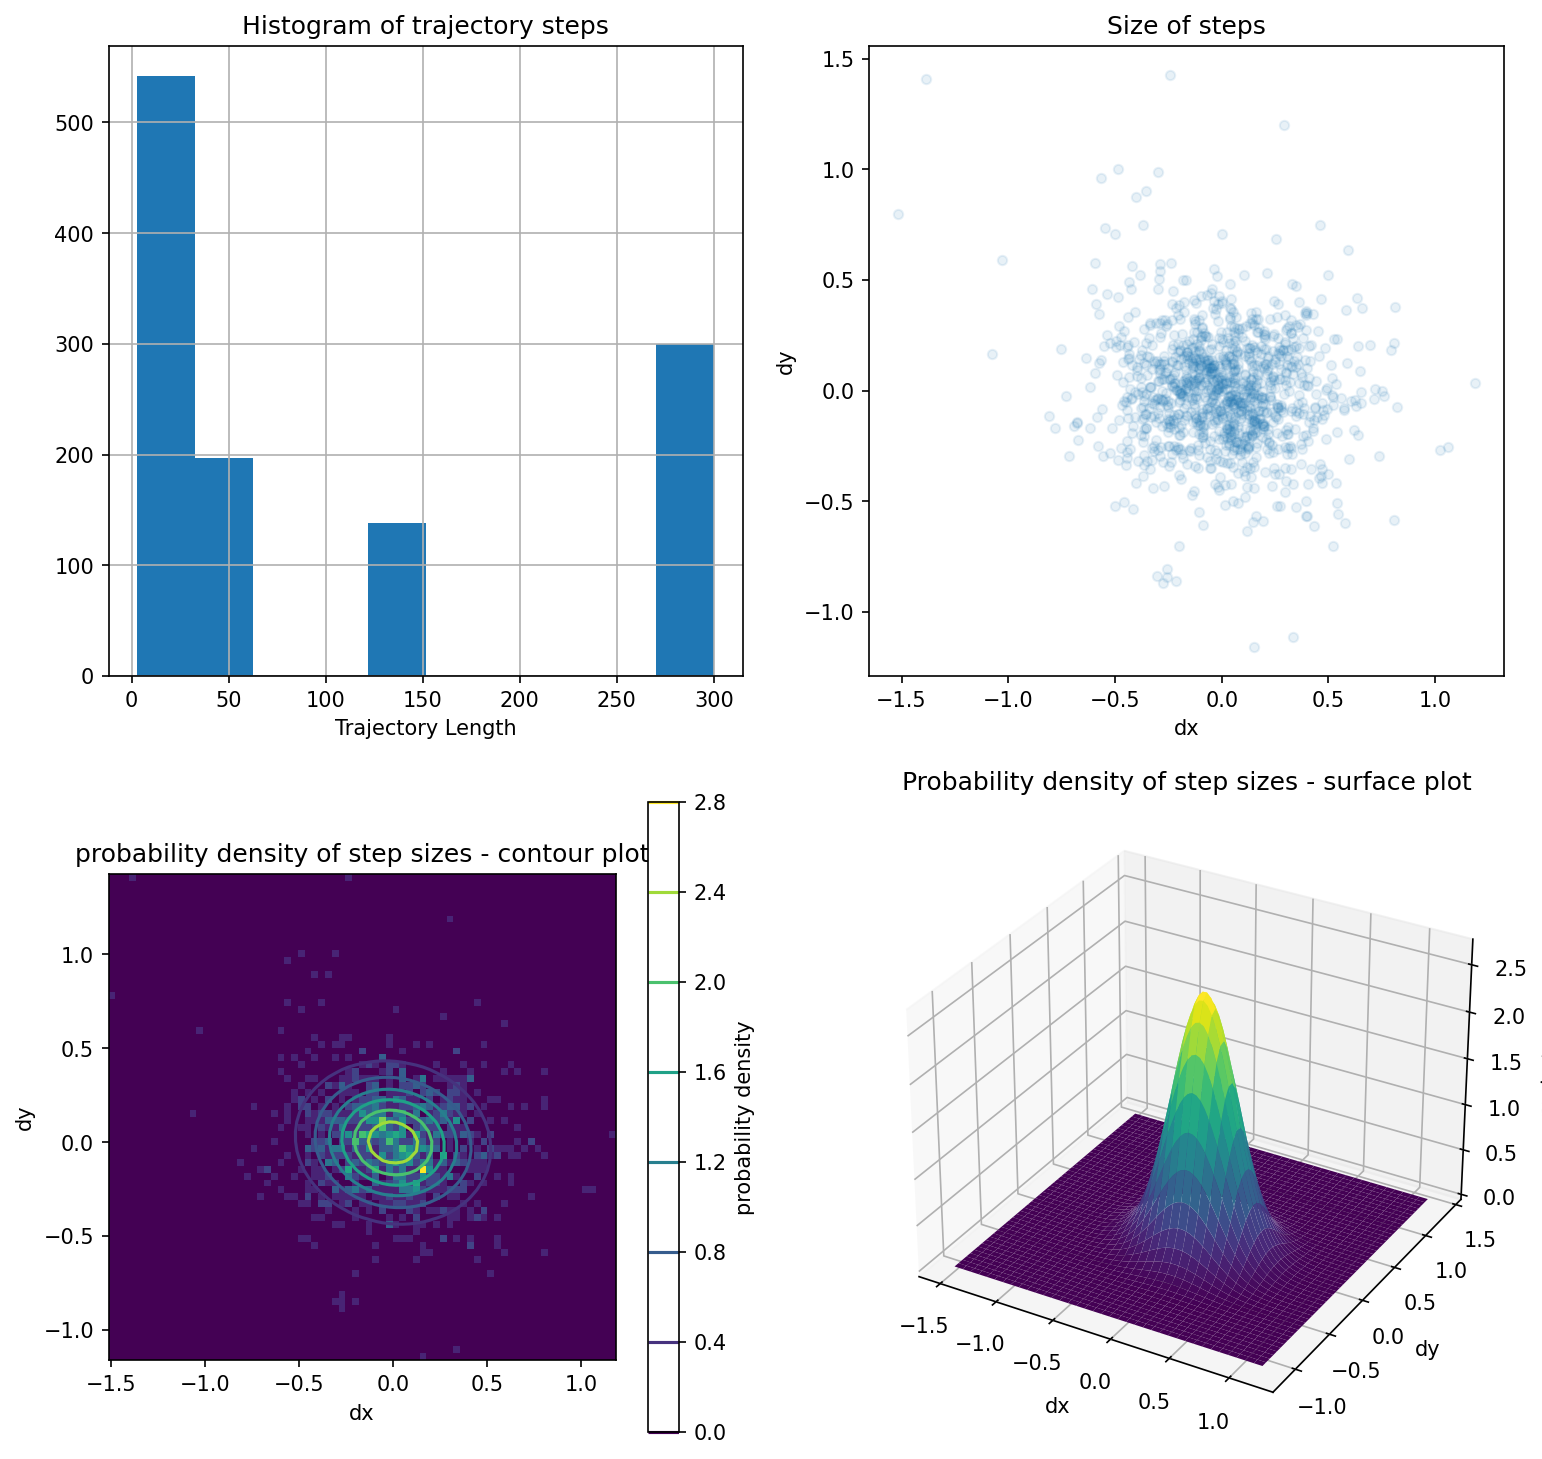

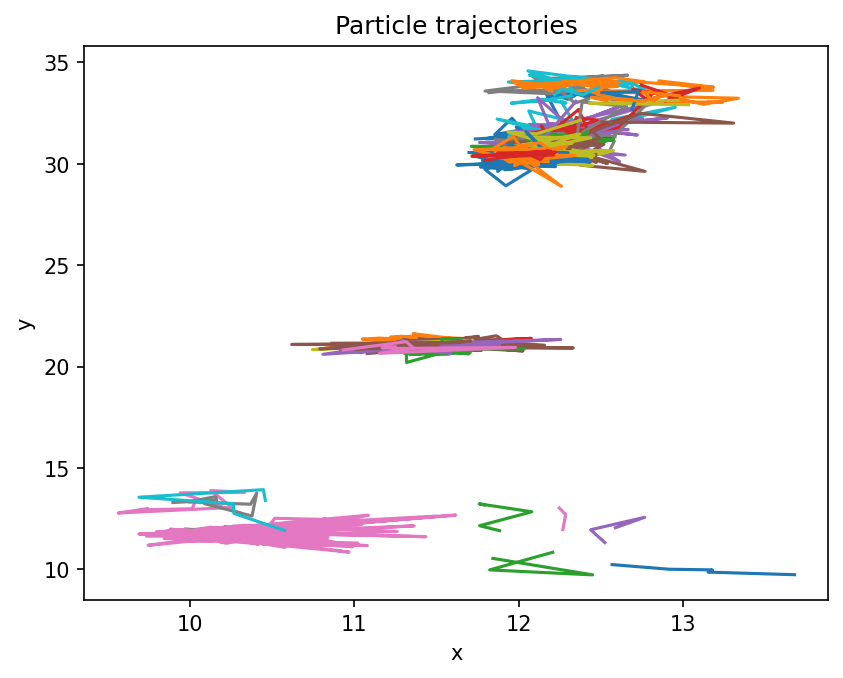

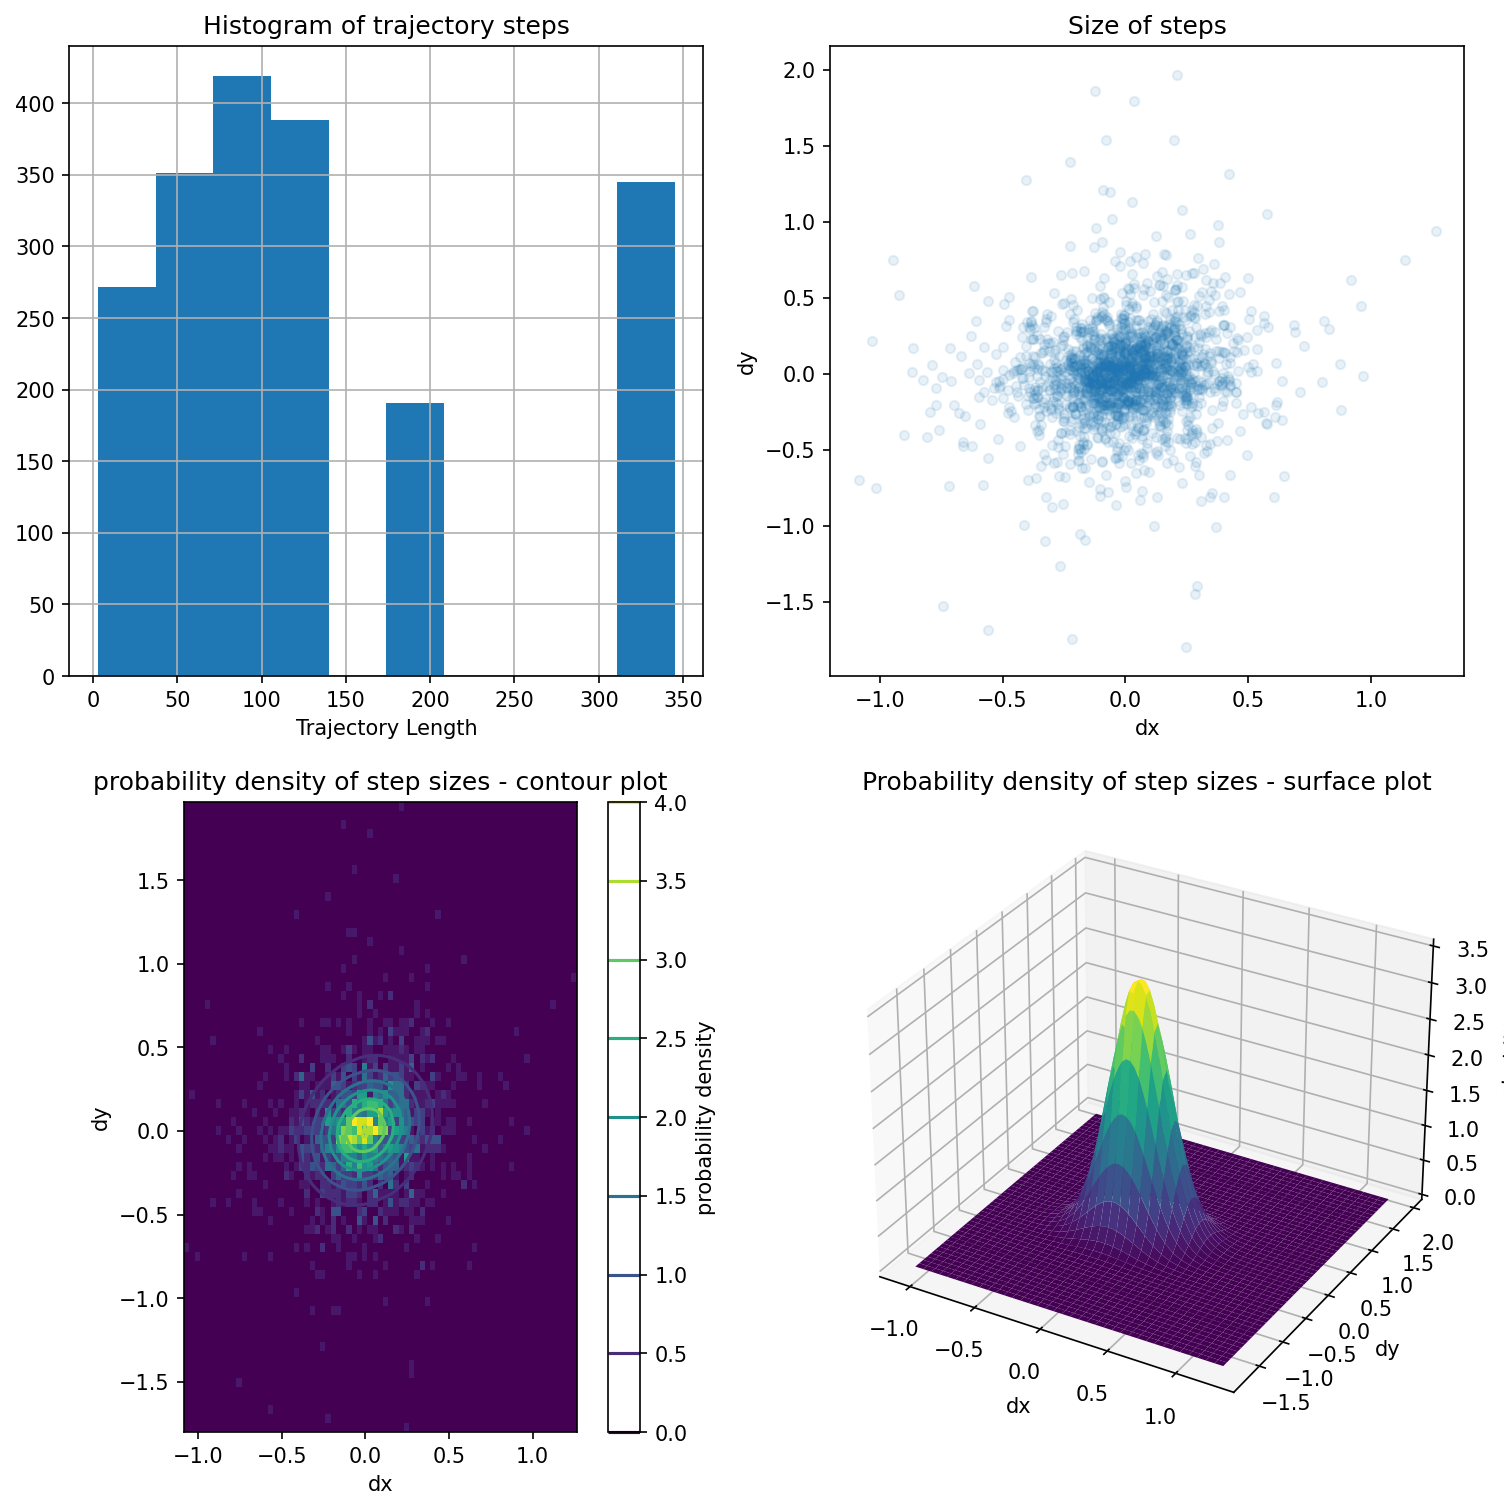

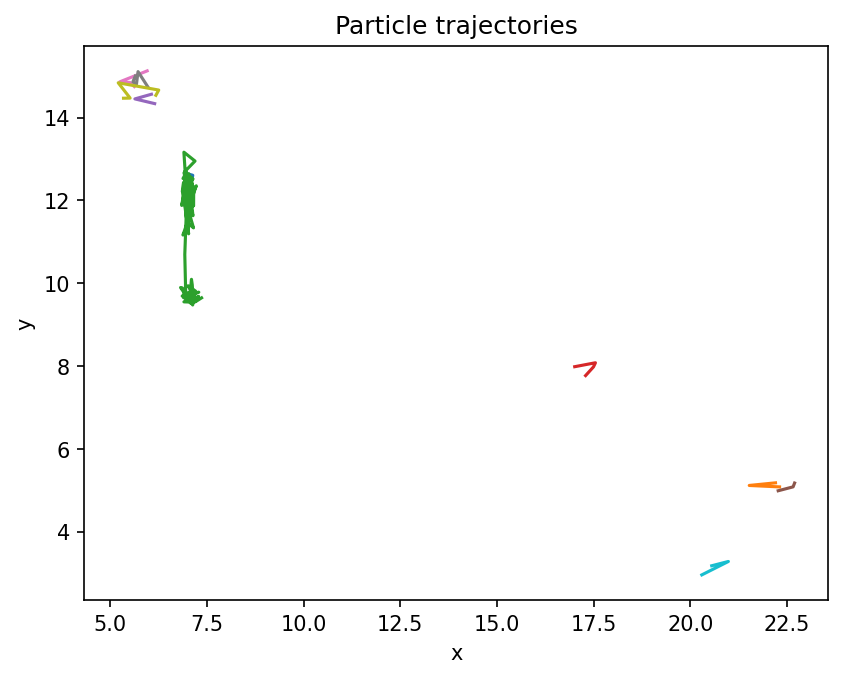

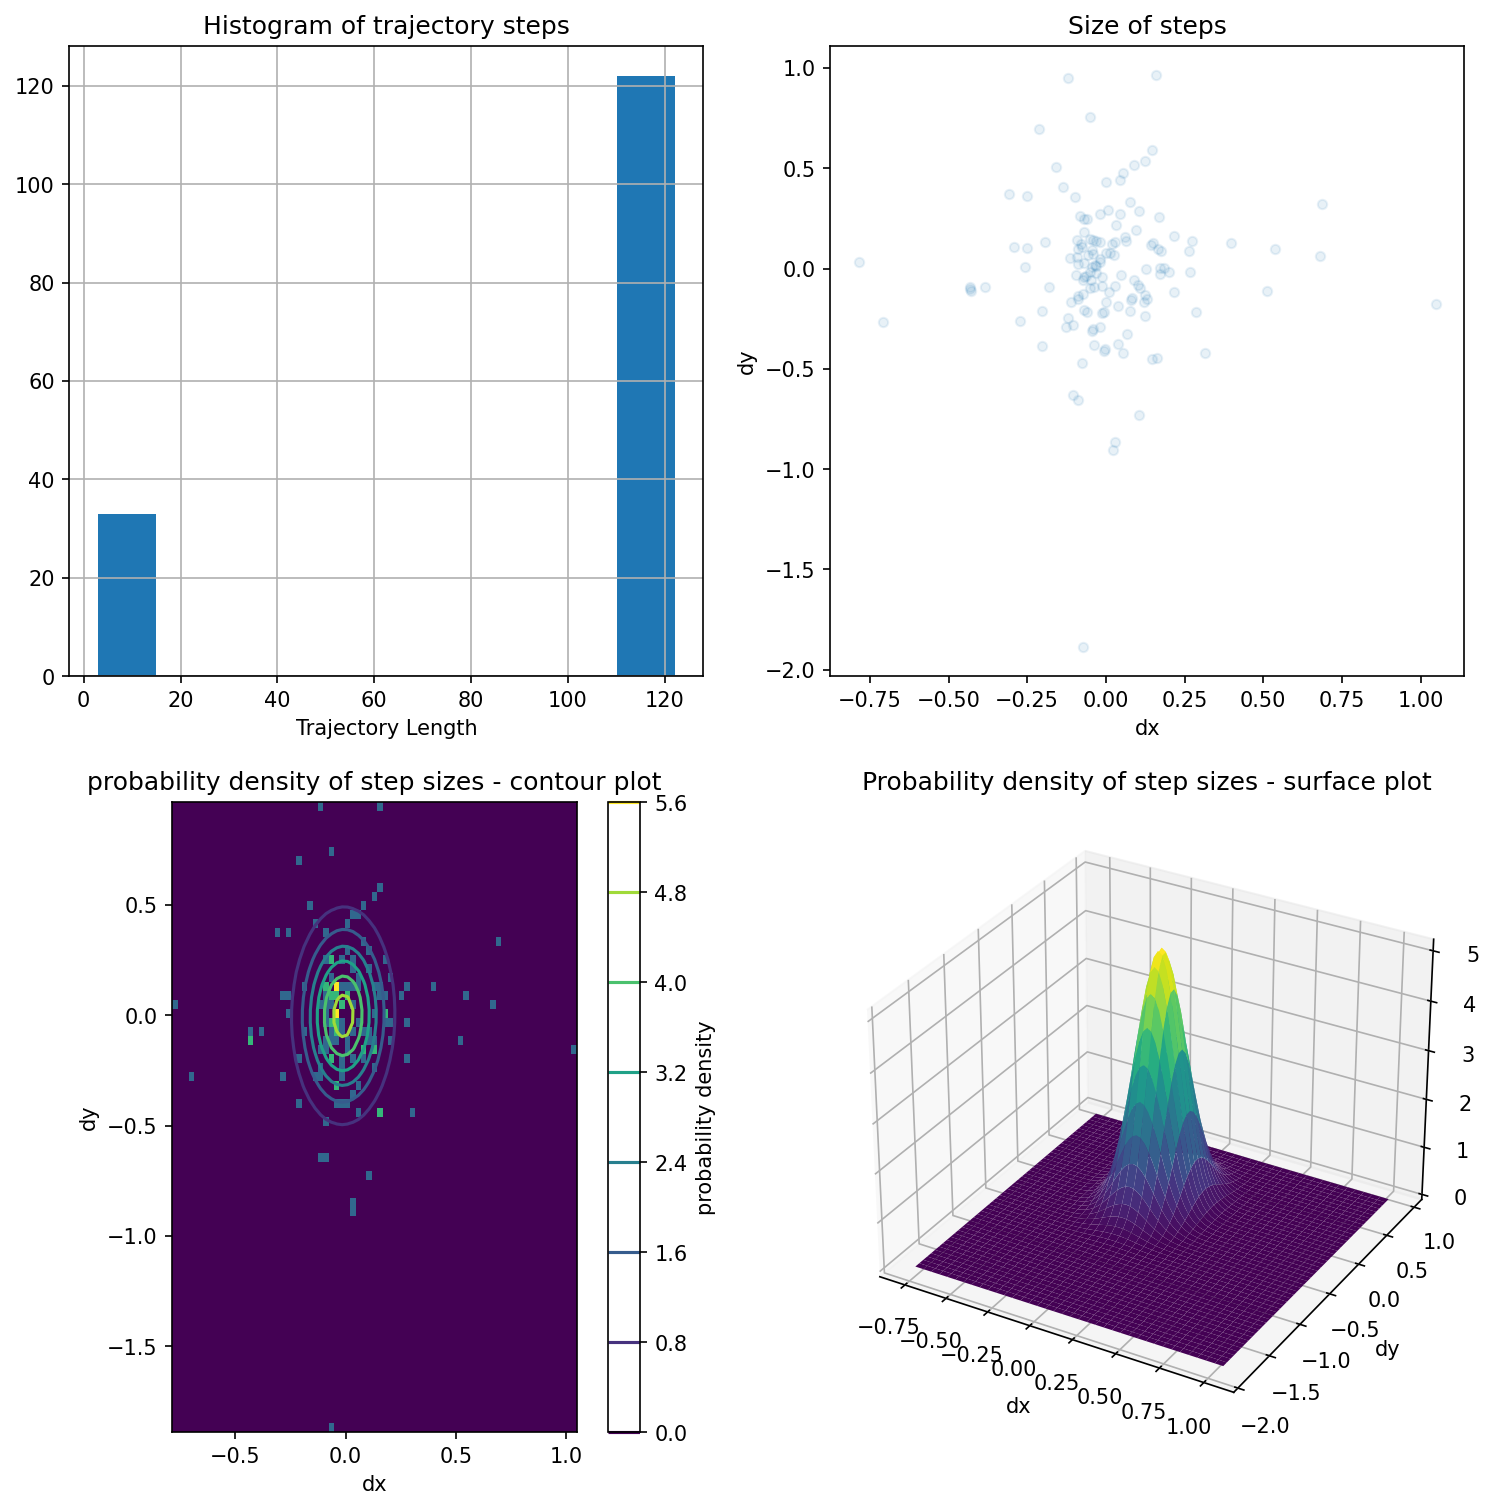

In [14]:
diff_coeff_e1 = []
diff_coeff_e2 = []
time_1000_nm = []
dwell_t = []
for file in in_files:
    print(file)
    basename = os.path.basename(file)
    out_dir = Path(f'{file_directory}\out_2')
    os.makedirs(out_dir, exist_ok=True)
    take_only_walkers_on_fibre_trajectory(file, out_dir / basename)
    basename_noext, ext = os.path.splitext(basename)
    !python -m picasso localize {out_dir/basename} --fit-method {fit_method} --box-side-length {box_side_length}  --gradient {min_gradient} --drift {drift} --pixelsize {px_to_nm}
    out_locs = out_dir / (basename_noext + "_locs.hdf5")
    new_suffix = f"__locs__fit_{fit_method}__box_{box_side_length}__gradient_{min_gradient}__drift_{drift}.hdf5"
    new_suffix = (
        f"__locs_{fit_method}_box{box_side_length}_grad{min_gradient}_drift{drift}.hdf5"
    )
    new_out_locs = out_dir / (basename_noext + new_suffix)
    print(new_out_locs)
    out_locs.with_suffix(".yaml").rename(new_out_locs.with_suffix(".yaml"))
    out_locs.rename(new_out_locs)
    locs = pd.read_hdf(new_out_locs, "locs")
    locs["mass"] = locs.photons

    tray = tp.link(locs, max_link_displacement_px)

    # count the length of trajectories
    tray_by_particle = tray.groupby(["particle"])
    tray["length"] = tray_by_particle["particle"].transform("count")
    dwell_time = tray["length"].mean()

    print("mean drift ", tp.compute_drift(tray).mean())

    # Exclude very short trays
    tray = tray.query(f"length>={min_tray_length}")

    steps = tray.groupby(["particle"]).apply(get_steps_from_df)
    steps["step_len"] = np.sqrt(steps.dx**2 + steps.dy**2)

    suffix = f"__link{max_link_displacement_px}_traylen{min_tray_length}"
    base_linked_tray = Path(f'{new_out_locs.with_suffix("")}{suffix}')
    tray_out = base_linked_tray.with_suffix(".tray.csv.gz")
    tray.to_csv(tray_out)
    steps_out = base_linked_tray.with_suffix(".steps.csv.gz")
    steps.to_csv(steps_out)


    stack = skio.imread(f'{out_dir}/{basename_noext}.tif')

    cmap_bright = plt.colormaps.get_cmap("Set1")
    set1_dict = { particle:cmap_bright(i%9) for i, particle in enumerate(list(set(tray.particle)))}

    ims = [] 

    fig = plt.figure("FRAMES", dpi=300, frameon=False)
    ax = fig.add_subplot(111)

    for n in range(stack.shape[0]):
        frame = ax.imshow(stack[n].astype('uint8'), cmap = 'Greys_r')
        if n in list(set(tray.frame)):
            t = []
            for k in list(set(tray[(tray["frame"]==n)].particle)):
                bright_color = set1_dict[k]
                t.append(ax.plot(tray[(tray["frame"]<=n) & (tray["particle"]==k)].x, tray[(tray["frame"]<=n) & (tray["particle"]==k)].y, linewidth=1, color=bright_color))
                plt.axis('off')
            number = ax.annotate(n,(1,1))
            artist_obj = [i[0] for i in t]
            artist_obj.append(frame)
            artist_obj.append(number)
            ims.append(artist_obj)

        else:
            ims.append([frame])
        if n >= 200:
            break

    ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True,repeat_delay=1000)

    output_path = f'{out_dir}/{basename_noext}_trajectories.mp4'

    ani.save(output_path)
    plt.close(fig)

    plt.figure()
    for i in set(tray.particle):
        plt.plot(tray[tray["particle"]==i].x, tray[tray["particle"]==i].y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Particle trajectories')
    plt.savefig(f'{out_dir}/{basename}_trajectories.png')

    #distribution_check = []
    steps_matrix = steps[['dx', 'dy']].to_numpy()
    num_columns = steps_matrix.shape[1]  
    normal_str = ''
    for var_idx in range(num_columns):
        anderson_data = anderson(steps_matrix[:, var_idx])
        is_normal = anderson_data.statistic < anderson_data.critical_values[1]
        #distribution_check += [is_normal]
        if not is_normal:
            normal = f"variable {f'dx' if var_idx == 0 else f'dy'} NOT normally distributed at {anderson_data.significance_level[1]}%\n"
        else:
            normal = f"variable {f'dx' if var_idx == 0 else f'dy'} normally distributed at {anderson_data.significance_level[1]}%\n"
        normal_str += normal 

    info = {}

    diff_info_out = base_linked_tray.with_suffix(".diff")

    x = steps['dx']
    y = steps['dy']
    bins = (75, 70)
    hist, xedges, yedges = np.histogram2d(x, y, bins=(75,50), density=True)
    xcent = (xedges[1:] + xedges[:-1])/2
    ycent = (yedges[1:] + yedges[:-1])/2
    x_grid, y_grid = np.meshgrid(xcent, ycent)
    xy = np.stack((x_grid.ravel(), y_grid.ravel())).T

    initial_guess = [0, 0, 1, 1, 0]
    bounds = ([-np.inf, -np.inf, 0, 0, -1], [np.inf, np.inf, np.inf, np.inf, 1])
    popt, _ = curve_fit(gaussian_2d, xy, hist.T.ravel(), initial_guess)
    #print(popt)
    mu = [popt[0], popt[1]]
    cov_matrix = [[popt[2], popt[4]], [popt[4], popt[3]]]

    e1, e2, rot = cov_to_axes_and_rotation(cov_matrix)
    #print(e1, e2)

    info["diff_long_nm_nm_s"] = float(e1*(px_to_nm**2)/(2*frame_to_s))
    info["diff_short_nm_nm_s"] = float(e2*(px_to_nm**2)/(2*frame_to_s))
    info["time_per_1000nm_s_long_axis"] = 1000 * 1000 / info["diff_long_nm_nm_s"] / 2
    info["average dwell time"] = float(dwell_time*frame_to_s)
    info["mean_step_nm_s"] = float(np.sqrt(2 * info["diff_long_nm_nm_s"] * frame_to_s) / frame_to_s)
    info["normality_str"] = normal_str
    info["anderson_test"] = anderson_data
    info["mu_x"] = float(round(mu[0], 3))
    info["mu_y"] = float(round(mu[1], 3))
    info["sigma_x"] = float(round(cov_matrix[0][0], 3))
    info["sigma_y"] = float(round(cov_matrix[1][1], 3))
    info["sigma_xy"] = float(round(cov_matrix[0][1], 3))
    write_yaml(info, diff_info_out)

    diff_coeff_e1 += [info["diff_long_nm_nm_s"]]
    diff_coeff_e2 += [info["diff_short_nm_nm_s"]]
    time_1000_nm += [info["time_per_1000nm_s_long_axis"]]
    dwell_t += [info["average dwell time"]]

    '''
    print(normal_str)
    print(f'the means of multivariate normal distrubution are: mu(dx) = {mu[0]:.3f}, mu(dy) = {mu[1]:.3f}')
    print(f'the standard deviations of the multivariate normal distribution are: sigma(dx) = {cov_matrix[0][0]:.3f}, sigma(dy) = {cov_matrix[1][1]:.3f}')
    print(f'the covariance of the multivariate normal distribution is: sigma(dxdy) = {cov_matrix[0][1]:.3f}')
    print("Diff along the long axis (in nm^2/s): ", info["diff_long_nm_nm_s"])
    print("Diff along the short axis (in nm^2/s): ", info["diff_short_nm_nm_s"])
    print("time per 1000nm (s): ", info["time_per_1000nm_s_long_axis"])
    print("mean step (nm/s) along the long axis:", info["mean_step_nm_s"])'''

    z = gaussian_2d(xy, *popt)
    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224, projection='3d')
    plt.sca(ax1)
    tray.length.hist()
    plt.xlabel("Trajectory Length")
    plt.title("Histogram of trajectory steps")
    plt.sca(ax2)
    steps.plot.scatter("dx", "dy", alpha=0.1, ax=ax2)
    plt.title("Size of steps")
    plt.sca(ax3)
    plt.hist2d(x,y, bins=bins, density=True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.contour(x_grid, y_grid, z.reshape(x_grid.shape), cmap='viridis')
    plt.colorbar(label='probability density')
    plt.xlabel('dx')
    plt.ylabel('dy')
    plt.title('probability density of step sizes - contour plot')
    plt.sca(ax4)
    ax4.plot_surface(x_grid, y_grid, z.reshape(x_grid.shape), cmap='viridis')
    plt.xlabel('dx')
    plt.ylabel('dy')
    ax4.set_zlabel('probability')
    plt.title('Probability density of step sizes - surface plot')

    fig.savefig(f'{out_dir}/{basename}_2d_fit.png')
diff_params = {'e1': diff_coeff_e1, 'e2': diff_coeff_e2, 'time_1000_nm': time_1000_nm, 'average_dwell_time': dwell_t}
diff_params_df = pd.DataFrame(diff_params)
diff_params_df.to_csv(f'{out_dir}/diff_info.csv')



In [ ]:
file_directory_2 = r"C:\Users\lizau\Desktop\walker_test\CODE_TEST\1a8\aligned\out"
in_files = glob.glob(f'{file_directory}/*.tif')
dwell_t = []
for file in in_files:
    print(file)
    basename = os.path.basename(file)
    out_dir = Path(f'{file_directory}\out_2')
    os.makedirs(out_dir, exist_ok=True)
    take_only_walkers_on_fibre_trajectory(file, out_dir / basename)
    basename_noext, ext = os.path.splitext(basename)
    !python -m picasso localize {out_dir/basename} --fit-method {fit_method} --box-side-length {box_side_length}  --gradient {min_gradient} --drift {drift} --pixelsize {px_to_nm}
    out_locs = out_dir / (basename_noext + "_locs.hdf5")
    new_suffix = f"__locs__fit_{fit_method}__box_{box_side_length}__gradient_{min_gradient}__drift_{drift}.hdf5"
    new_suffix = (
        f"__locs_{fit_method}_box{box_side_length}_grad{min_gradient}_drift{drift}.hdf5"
    )
    new_out_locs = out_dir / (basename_noext + new_suffix)
    print(new_out_locs)
    out_locs.with_suffix(".yaml").rename(new_out_locs.with_suffix(".yaml"))
    out_locs.rename(new_out_locs)
    locs = pd.read_hdf(new_out_locs, "locs")
    locs["mass"] = locs.photons

    tray = tp.link(locs, max_link_displacement_px)

    # count the length of trajectories
    tray_by_particle = tray.groupby(["particle"])
    tray["length"] = tray_by_particle["particle"].transform("count")
    dwell_time = tray["length"].mean()